### Summary

This notebook presents a typical use of neural network to time series of the EPRI project.

It is strongly suggested to read the Neural Network report provided in the Report folder of the shared box in order to understand the various pre-processing methods we refer to.

Choice was made to leave several possibly conflicting lines of code in the cells; instructions were left to indicate when commenting out lines was desirable.

A lot of ad hoc modifications are possible, especially at the stage of loading the data, as this is the moment where data is preprocessed and the input and output are determined. When moving the code to an implementable .py file **one should rewrite preprocessing into a pipeline, so that raw data could be fed to the machine.**

### How to reproduce results from the Neural Network report:

#### Basic dataset

In order to reproduce the results in the report, follow this procedure:

1) *No subsampling.* For each of the 'choose one of two' mentions in part 2, comment out b). Make sure the second cell of part 2 loads `X_5years` and `Y_5years`.

2) *Downsizing to day-by-day series using the 70th percentile of power for each day.* In part 2.III.iv, edit the tail of the `groupby` line to be `.quantile(q=0.7)`

3) *No other preprocessing.* Comment out part 2.III.iii

4) Make sure that the downsizing (part 2.III.iv) processes the `Power` (as opposed to `Power_norm` or `Power_scaled`).

5) *Model naming.* Part 3.III, rename the model to your convenience.

Training converges to optimal solution within ~500 epochs. Training can be interrupted midway by interrupting the jupyter notebook kernel; best model found during training will still be saved.

#### Soiling, Weather, Soil and Weather datasets

2-year subsampling performing consistently worse than 3-year subsampling and no subsampling, while 4-year subsampling never outperformed 3-year subsampling. Thus we decided not to include these other subsampling methods in this jupyter notebook. If needed it shouldn't be too hard to take example on the 3-year subsampling coded here and adapt it for 2-year or 4-year subsampling.

The various daily aggregations pre-processing can be tested by modifying the tail of the `groupby` line in part 2.III.iv accordingly:
- `.quantile(q=0.7)` for the 70th percentile of power for each day
- `.median()` for the median power for each day
- `.mean()` for the mean power for each day

If you want to use a power clipping function, simply adapt part 2.III.iii by commenting out all but power clipping lines.

#### Warning about optional preprocessing (part 2.III.iii and following)

Most of the preprocessing methods create a new column in the dataframe each time preprocessing is applied. If you want to go through several preprocessing steps (say, scaling, then POA-normalization) make sure you edit the code accordingly so that each step's input corresponds to the output of the previous step (in the example above: scaling takes `df.Power` as input, and produces `df.Power_scaled`; then, normalization takes `df.Power_scaled` as input and produces `df.Power_normalized`). Also, make sure that part 2.III.iv takes as input the final output of the hitherto preprocessing (in the above example, `df.Power_normalized`).

### 1. Imports and functions

In [252]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import sklearn
from sklearn import metrics
import math
from tensorflow.keras import initializers
import sys
from tensorflow.keras import backend as K
import datetime

# TO EDIT: replace path with your own path to Aug20_Epri/src/data
# But only needed if you want to use any function from make_dataset.py
sys.path.insert(1, '/Users/antoine/ml/S2DS/EPRI/Aug20_Epri/src/data')

from make_dataset import remove_clipping_with_flexible_window as remove_clip_flex
from make_dataset import remove_clipping_with_universal_window as remove_clip_univ

tf.random.set_seed(42)
np.random.seed(42)

In [303]:
# Converting a decay series into a decay rate.
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]


# Our personal activation function for the last layer of the neural network
def paf(x):
    return 0.21*K.sigmoid(x)+0.8
tf.keras.utils.get_custom_objects().update({'paf': paf})


# Generating noise to test normalization by irradiance with sensor drift
# Parameters A1 and K1 can be adjusted
def generate_noise(series_length):
    freq = np.fft.rfftfreq(series_length)
    sp = []
    A1 = 0.002
    K1 = 1-1e-3
    for freq_iter in np.nditer(freq):
        if freq_iter == 0:
            sp.append(0)
        else:
            std_iter = A1*freq_iter**(-K1)
            sp_real = np.random.normal(0, std_iter)
            sp_imag = np.random.normal(0, std_iter)
            sp.append(sp_real + 1j*sp_imag)
    sp = np.asarray(sp)
    return np.fft.irfft(sp)+1


# Smoothing a power series by taking a rolling median of the series.
# window is the size of the subarray over which median is taken.
# step is the number of steps by which the median window is shifted
# to compute the next median.
def rolling_median(s, window, step):
    s = pd.Series([0]*(window//2)+list(s)+[0]*(window//2+window%2))
    vert_idx_list = np.arange(0, s.size - window, step)
    hori_idx_list = np.arange(window)
    A, B = np.meshgrid(hori_idx_list, vert_idx_list)
    idx_array = A + B
    x_array = s.values[idx_array]
    idx = s.index[vert_idx_list + int(window/2.)]
    d = np.quantile(x_array,0.5, axis=1)
    return np.array(d)

### 2. Loading and pre-processing data

In [314]:
# I. Creating datasets of 5-year-long and 3-year-long series
#    X being the input, Y being the target

# Choose one of two (comment out the choice not needed)

# a) 5-year-long input (no subsampling)
X_5years = np.empty((0, 365*5+1), float)
Y_5years = np.empty((0, 365*5+1), float)

# b) 3-year-long input (using subsampling)
X_3years = np.empty((0, 365*3), float)
Y_3years = np.empty((0, 365*3), float)


# II. Choosing the dataset. Comment out datasets you don't need.

datasets_addresses = [
    "synthetic_basic/synthetic_basic",
    "synthetic_soil/synthetic_soil",
    "synthetic_weather/synthetic_weather",
    "synthetic_soil_weather/synthetic_soil_weather",
    "synthetic_soil_weather_locations/synthetic_soil_weather_locations"
]

# III. Loading, preprocessing and adding each time series to input and target arrays

for dataset in datasets_addresses:
    
    files_count = len(
        [f for f in os.listdir("./data/raw/"+dataset.split("/")[0])
         if f.endswith('.pkl')
         and f.startswith(dataset.split("/")[1]+"_")
         and os.path.isfile(os.path.join("./data/raw/"+dataset.split("/")[0], f))]
    )
        
    for i in range(1, files_count+1):
        print("Loading file #"+str(i)+" from dataset "+dataset.split("/")[0])
            
        # i. Loading a time series
        index = str(i)
        if i < 10:
            index = "00"+str(i)
        elif i <100:
            index = "0"+str(i)
        df = pd.read_pickle("./data/raw/"+dataset+"_"+index+".pkl", "gzip")
        
        # ii. Adding target to the target list, taking for each day the value of the
        #     degradation at the first minute of the day.
        
        # Choose one of two:
        
        # a) For 5-year-long input (no subsampling)
        Y_5years = np.vstack([
            Y_5years,
            np.array(df[df.index.time == datetime.time(0,0)].Degradation)])
    
        # b) For 3-year-long input (subsampling)
        for j in range(0,3):
            Y_3years = np.vstack([
                Y_3years,
                np.array(df[df.index.time == datetime.time(0,0)].Degradation[:365*3])])

        # iii. Optional preprocessing. Comment out any that is not needed.
        
        # Applying power clipping removal
        df["minute_of_day"] = df.index.hour*60+df.index.minute
        df = remove_clip_flex(df)
        
        # Scaling the power signal
        df["Power_scaled"] = (df.Power+1)/df.Power.max()
        
        # Normalizing by irradiance with sensor drift
        drift_noise = generate_noise(len(df))
        df["Drifting_POA"] = df.POA * drift_noise
        df = df[df.Drifting_POA > 1.0]
        df["Power_norm"] = df.Power_scaled / df.Drifting_POA
        
        # iv. Downsizing to day-by-day time series.
        #     The function at the tail of the groupby line can be edited to change
        #     the downsizing method.
        
        preprocessed_power = np.array(
            df.groupby(df.index.date, as_index=False).Power_scaled.quantile(q=0.7)
        ).reshape(365*5+1)
        
        # Optional: smoothing the power signal with a rolling median or savgol filter.
        # Usually one of the two lines suffice.
        # Function parameters can be adapted at will.
        
        preprocessed_power = rolling_median(preprocessed_power, 30, 1)
        preprocessed_power = savgol_filter(preprocessed_power, 30, 2)
        
        # Choose one of two:
        
        # a) For 5-year-long input (no subsampling)
        X_5years = np.vstack([
            X_5years,
            preprocessed_power
        ])
        
        # b) For 3-year-long input (subsampling)
        for j in range(0,3):
            X_3years = np.vstack([
                X_3years,
                preprocessed_power[365*j:365*(j+3)]
            ])

print("All done!")


Loading file #1 from dataset synthetic_basic
Loading file #2 from dataset synthetic_basic
Loading file #3 from dataset synthetic_basic
Loading file #4 from dataset synthetic_basic
Loading file #5 from dataset synthetic_basic
Loading file #6 from dataset synthetic_basic
Loading file #7 from dataset synthetic_basic
Loading file #8 from dataset synthetic_basic
Loading file #9 from dataset synthetic_basic
Loading file #10 from dataset synthetic_basic
Loading file #11 from dataset synthetic_basic
Loading file #12 from dataset synthetic_basic
Loading file #13 from dataset synthetic_basic
Loading file #14 from dataset synthetic_basic
Loading file #15 from dataset synthetic_basic
Loading file #16 from dataset synthetic_basic
Loading file #17 from dataset synthetic_basic
Loading file #18 from dataset synthetic_basic
Loading file #19 from dataset synthetic_basic
Loading file #20 from dataset synthetic_basic
Loading file #21 from dataset synthetic_basic
Loading file #22 from dataset synthetic_bas

In [315]:
# IV. Choose the sample set & target you wanna train on.
#     This step is added in case you want to load
#     BOTH 3-year-long AND 5-year-long input.

X = X_3years
Y = Y_3years

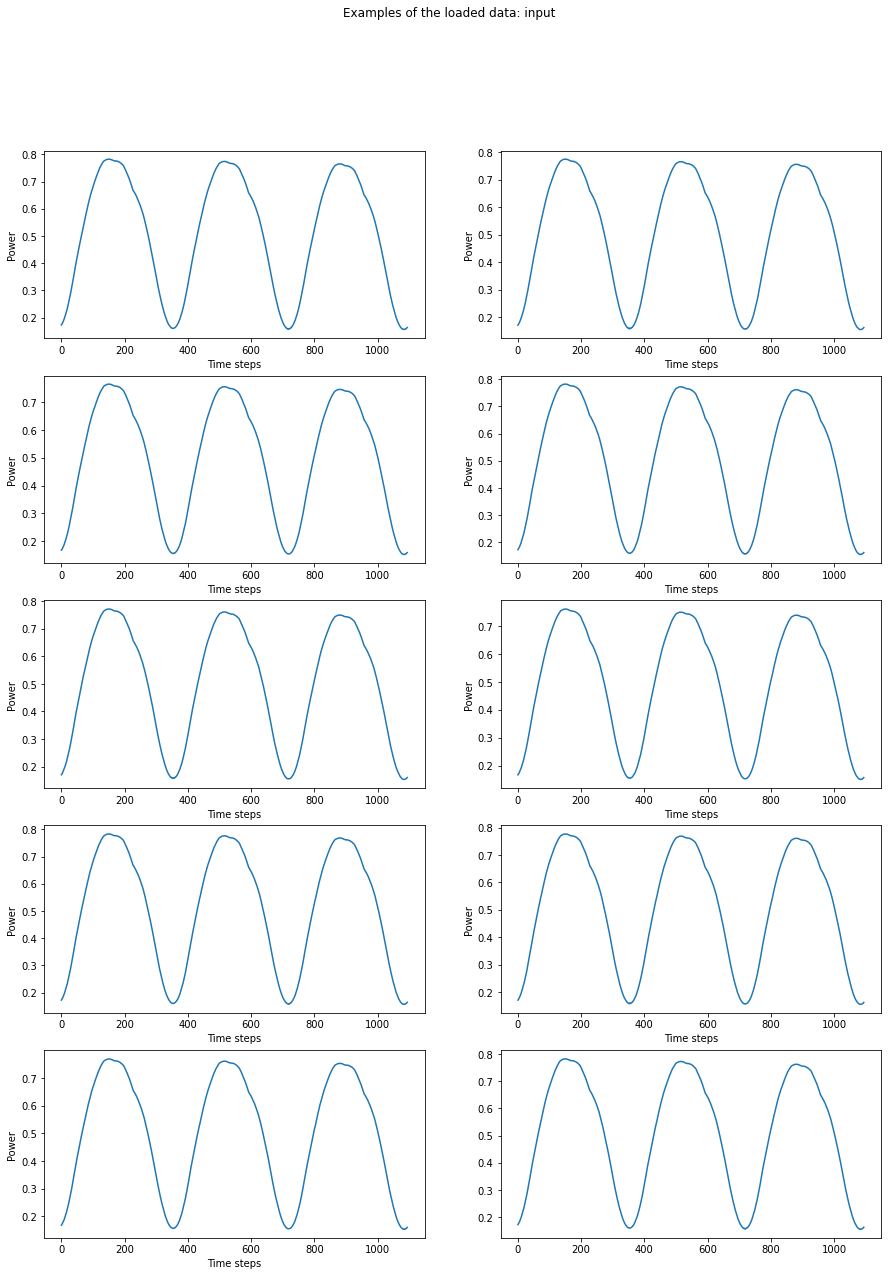

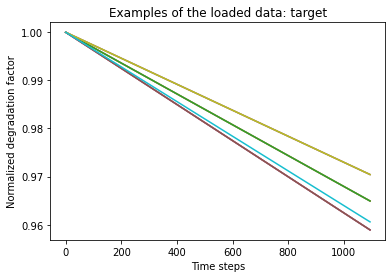

In [316]:
# V. Optional: check that the data looks like what you expect.

plt.figure(figsize=(15,20))
plt.suptitle("Examples of the loaded data: input")
for i in range(0, 10):
    plt.xlabel("Time steps")
    plt.ylabel("Power")
    plt.subplot(5,2,i+1)
    plt.plot(X[i])
plt.show()

plt.figure()
plt.title("Examples of the loaded data: target")
plt.xlabel("Time steps")
plt.ylabel("Normalized degradation factor")
for i in range(0, 10):
    plt.plot(Y[i])
plt.show()

### 3. Training the neural network

In [317]:
# I. Dividing the data into training, validation and test sets,
#    in proportion 75%-15%-15%

train_index = int(len(X)*0.7)
valid_index = int(len(X)*0.85)

X_train = X[:train_index]
X_valid = X[train_index:valid_index]
X_test = X[valid_index:]
Y_train = Y[:train_index]
Y_valid = Y[train_index:valid_index]
Y_test = Y[valid_index:]

# II. Shuffling the datasets so that, in the case of 3-year-long data,
#     mini-batch training doesn't get a streak of samples that were
#     all extracted from the same time series.
train_shuffle = np.random.permutation(len(X_train))
valid_shuffle = np.random.permutation(len(X_valid))

X_train = X_train[train_shuffle]
Y_train = Y_train[train_shuffle]
X_valid = X_valid[valid_shuffle]
Y_valid = Y_valid[valid_shuffle]

In [11]:
# III. Initializing parameters necessary for training, and creating a folder
#      to store the model's log and results
run_index = 0
model_name = "my_nn_model"

current_directory = os.getcwd()
final_directory = os.path.join(current_directory, model_name)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)

In [318]:
# IV. Training the neural network

# i. To update the name of the model, indicating this is the nth run
run_index = run_index + 1

# ii. Optional: creating and sending log to tensorboard.
run_logdir = os.path.join(os.curdir, model_name+"_log", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# iii. Saving the best model so far during training.
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name+"_run_"+str(run_index)+".h5", save_best_only=True)

time_series_length = len(X[0])

# iv. Creating and compiling the model.
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=[time_series_length]))

for i in range(0, 6):
    model.add(
        keras.layers.Dense(
            time_series_length,
            activation="elu",
            kernel_initializer="he_normal"
        ))
    model.add(keras.layers.BatchNormalization())
    
model.add(
    keras.layers.Dense(
        len(Y[0]),
        activation="paf",
        kernel_initializer="he_normal"
    ))

model.compile(loss='mse', optimizer=keras.optimizers.Adam())

# v. Training the model.
print("Training run #"+str(run_index))
history = model.fit(X_train,
                    Y_train,
                    epochs=1000,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Training run #53
Epoch 1/1000
4/4 [==============================] - 0s 119ms/step - loss: 0.2645 - val_loss: 0.4075
Epoch 2/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.2215 - val_loss: 0.4756
Epoch 3/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.2012 - val_loss: 0.4716
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1923 - val_loss: 0.4694
Epoch 5/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1859 - val_loss: 0.4762
Epoch 6/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1794 - val_loss: 0.4811
Epoch 7/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1724 - val_loss: 0.4765
Epoch 8/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1637 - val_loss: 0.4870
Epoch 9/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1532 - val_loss: 0.4787
Epoch 10/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.1395 - val_loss

4/4 [==============================] - 0s 56ms/step - loss: 1.2511e-05 - val_loss: 4.5377e-05
Epoch 80/1000
4/4 [==============================] - 0s 66ms/step - loss: 1.3365e-05 - val_loss: 3.9086e-05
Epoch 81/1000
4/4 [==============================] - 0s 51ms/step - loss: 2.0042e-05 - val_loss: 2.5730e-05
Epoch 82/1000
4/4 [==============================] - 0s 22ms/step - loss: 2.0829e-05 - val_loss: 2.9128e-05
Epoch 83/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.0509e-05 - val_loss: 3.7892e-05
Epoch 84/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3118e-05 - val_loss: 3.4768e-05
Epoch 85/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.6531e-05 - val_loss: 2.6074e-05
Epoch 86/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.7533e-05 - val_loss: 4.9189e-05
Epoch 87/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.8825e-05 - val_loss: 3.6653e-05
Epoch 88/1000
4/4 [=======================

4/4 [==============================] - 0s 23ms/step - loss: 7.9645e-06 - val_loss: 1.1814e-05
Epoch 155/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.4871e-06 - val_loss: 1.4421e-05
Epoch 156/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.3799e-06 - val_loss: 2.0384e-05
Epoch 157/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.2950e-05 - val_loss: 1.8988e-05
Epoch 158/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.0828e-05 - val_loss: 2.6443e-05
Epoch 159/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.4417e-05 - val_loss: 1.7359e-05
Epoch 160/1000
4/4 [==============================] - 0s 24ms/step - loss: 9.2766e-06 - val_loss: 1.6588e-05
Epoch 161/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.5096e-05 - val_loss: 4.6176e-05
Epoch 162/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.8892e-05 - val_loss: 1.7477e-05
Epoch 163/1000
4/4 [==============

4/4 [==============================] - 0s 23ms/step - loss: 1.1783e-05 - val_loss: 2.6261e-05
Epoch 230/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.0721e-05 - val_loss: 2.1819e-05
Epoch 231/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.3847e-05 - val_loss: 1.4416e-05
Epoch 232/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.1434e-05 - val_loss: 2.8847e-05
Epoch 233/1000
4/4 [==============================] - 0s 22ms/step - loss: 8.4051e-06 - val_loss: 1.8402e-05
Epoch 234/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.9714e-06 - val_loss: 3.1637e-05
Epoch 235/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.0560e-05 - val_loss: 3.9631e-05
Epoch 236/1000
4/4 [==============================] - 0s 24ms/step - loss: 2.7055e-05 - val_loss: 4.7885e-05
Epoch 237/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.6678e-05 - val_loss: 2.1350e-05
Epoch 238/1000
4/4 [==============

4/4 [==============================] - 0s 23ms/step - loss: 3.0036e-05 - val_loss: 5.8293e-05
Epoch 305/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.7481e-05 - val_loss: 3.8405e-05
Epoch 306/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.5620e-06 - val_loss: 3.0440e-05
Epoch 307/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.2266e-06 - val_loss: 4.6613e-05
Epoch 308/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.1170e-05 - val_loss: 2.4819e-05
Epoch 309/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.1833e-05 - val_loss: 1.4489e-05
Epoch 310/1000
4/4 [==============================] - 0s 24ms/step - loss: 7.8460e-06 - val_loss: 1.7050e-05
Epoch 311/1000
4/4 [==============================] - 0s 25ms/step - loss: 7.3590e-06 - val_loss: 1.2550e-05
Epoch 312/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.0756e-05 - val_loss: 4.7631e-05
Epoch 313/1000
4/4 [==============

4/4 [==============================] - 0s 24ms/step - loss: 9.1354e-06 - val_loss: 5.0341e-05
Epoch 380/1000
4/4 [==============================] - 0s 31ms/step - loss: 6.7678e-06 - val_loss: 5.7486e-05
Epoch 381/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.1648e-05 - val_loss: 8.3357e-05
Epoch 382/1000
4/4 [==============================] - 0s 25ms/step - loss: 2.6018e-05 - val_loss: 6.5808e-05
Epoch 383/1000
4/4 [==============================] - 0s 26ms/step - loss: 2.9404e-05 - val_loss: 1.0827e-04
Epoch 384/1000
4/4 [==============================] - 0s 24ms/step - loss: 5.1719e-05 - val_loss: 1.0698e-04
Epoch 385/1000
4/4 [==============================] - 0s 25ms/step - loss: 3.2940e-05 - val_loss: 1.0517e-04
Epoch 386/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.6859e-05 - val_loss: 6.5082e-05
Epoch 387/1000
4/4 [==============================] - 0s 26ms/step - loss: 3.8546e-05 - val_loss: 1.0267e-04
Epoch 388/1000
4/4 [==============

4/4 [==============================] - 0s 24ms/step - loss: 3.9214e-05 - val_loss: 1.1278e-04
Epoch 455/1000
4/4 [==============================] - 0s 24ms/step - loss: 7.3283e-05 - val_loss: 8.6113e-05
Epoch 456/1000
4/4 [==============================] - 0s 25ms/step - loss: 5.9555e-05 - val_loss: 1.0748e-04
Epoch 457/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.3107e-04 - val_loss: 3.5994e-04
Epoch 458/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.4076e-04 - val_loss: 5.8615e-04
Epoch 459/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.0618e-04 - val_loss: 4.4241e-04
Epoch 460/1000
4/4 [==============================] - 0s 22ms/step - loss: 7.2293e-05 - val_loss: 2.9720e-04
Epoch 461/1000
4/4 [==============================] - 0s 22ms/step - loss: 7.3306e-05 - val_loss: 3.5848e-04
Epoch 462/1000
4/4 [==============================] - 0s 24ms/step - loss: 8.3346e-05 - val_loss: 1.5710e-04
Epoch 463/1000
4/4 [==============

4/4 [==============================] - 0s 26ms/step - loss: 2.1618e-05 - val_loss: 1.1898e-04
Epoch 530/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.3536e-05 - val_loss: 3.4471e-05
Epoch 531/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.1732e-05 - val_loss: 5.2608e-05
Epoch 532/1000
4/4 [==============================] - 0s 25ms/step - loss: 9.7129e-06 - val_loss: 5.8452e-05
Epoch 533/1000
4/4 [==============================] - 0s 23ms/step - loss: 7.7873e-06 - val_loss: 7.5252e-05
Epoch 534/1000
4/4 [==============================] - 0s 24ms/step - loss: 6.6314e-06 - val_loss: 1.4271e-04
Epoch 535/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.7214e-06 - val_loss: 1.2469e-04
Epoch 536/1000
4/4 [==============================] - 0s 27ms/step - loss: 8.8967e-06 - val_loss: 7.1781e-05
Epoch 537/1000
4/4 [==============================] - 0s 25ms/step - loss: 6.0248e-06 - val_loss: 6.5757e-05
Epoch 538/1000
4/4 [==============

4/4 [==============================] - 0s 26ms/step - loss: 8.1128e-06 - val_loss: 6.8323e-05
Epoch 605/1000
4/4 [==============================] - 0s 26ms/step - loss: 5.3081e-06 - val_loss: 1.0538e-04
Epoch 606/1000
4/4 [==============================] - 0s 22ms/step - loss: 7.1465e-06 - val_loss: 4.4777e-05
Epoch 607/1000
4/4 [==============================] - 0s 22ms/step - loss: 9.3442e-06 - val_loss: 8.8251e-05
Epoch 608/1000
4/4 [==============================] - 0s 22ms/step - loss: 7.8008e-06 - val_loss: 4.1183e-05
Epoch 609/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.1854e-06 - val_loss: 4.1774e-05
Epoch 610/1000
4/4 [==============================] - 0s 23ms/step - loss: 5.5151e-06 - val_loss: 4.5670e-05
Epoch 611/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.8890e-06 - val_loss: 5.4207e-05
Epoch 612/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.2417e-05 - val_loss: 5.9024e-05
Epoch 613/1000
4/4 [==============

4/4 [==============================] - 0s 23ms/step - loss: 9.2370e-05 - val_loss: 3.0596e-04
Epoch 680/1000
4/4 [==============================] - 0s 22ms/step - loss: 5.6808e-05 - val_loss: 1.5951e-04
Epoch 681/1000
4/4 [==============================] - 0s 26ms/step - loss: 5.1459e-05 - val_loss: 2.1761e-04
Epoch 682/1000
4/4 [==============================] - 0s 23ms/step - loss: 9.4050e-05 - val_loss: 8.6365e-05
Epoch 683/1000
4/4 [==============================] - 0s 23ms/step - loss: 7.6212e-05 - val_loss: 0.0011
Epoch 684/1000
4/4 [==============================] - 0s 22ms/step - loss: 3.4375e-05 - val_loss: 0.0012
Epoch 685/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.8537e-05 - val_loss: 0.0016
Epoch 686/1000
4/4 [==============================] - 0s 22ms/step - loss: 6.3774e-05 - val_loss: 0.0017
Epoch 687/1000
4/4 [==============================] - 0s 22ms/step - loss: 5.6329e-05 - val_loss: 5.3459e-04
Epoch 688/1000
4/4 [==============================

4/4 [==============================] - 0s 23ms/step - loss: 7.3079e-06 - val_loss: 4.8278e-06
Epoch 755/1000
4/4 [==============================] - 0s 22ms/step - loss: 3.2567e-06 - val_loss: 7.2725e-06
Epoch 756/1000
4/4 [==============================] - 0s 23ms/step - loss: 4.7455e-06 - val_loss: 4.9013e-06
Epoch 757/1000
4/4 [==============================] - 0s 24ms/step - loss: 4.0935e-06 - val_loss: 6.6130e-06
Epoch 758/1000
4/4 [==============================] - 0s 22ms/step - loss: 6.8638e-06 - val_loss: 8.4296e-06
Epoch 759/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.9378e-06 - val_loss: 8.8452e-06
Epoch 760/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.3668e-06 - val_loss: 7.4903e-06
Epoch 761/1000
4/4 [==============================] - 0s 56ms/step - loss: 6.5245e-06 - val_loss: 4.0236e-06
Epoch 762/1000
4/4 [==============================] - 0s 23ms/step - loss: 6.3506e-06 - val_loss: 7.0641e-06
Epoch 763/1000
4/4 [==============

4/4 [==============================] - 0s 22ms/step - loss: 1.3798e-05 - val_loss: 1.8607e-05
Epoch 830/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.8418e-05 - val_loss: 5.0588e-05
Epoch 831/1000
4/4 [==============================] - 0s 23ms/step - loss: 2.4198e-05 - val_loss: 3.4799e-05
Epoch 832/1000
4/4 [==============================] - 0s 22ms/step - loss: 2.3228e-05 - val_loss: 8.6357e-05
Epoch 833/1000
4/4 [==============================] - 0s 25ms/step - loss: 2.2533e-05 - val_loss: 1.7377e-04
Epoch 834/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.6116e-05 - val_loss: 2.6418e-04
Epoch 835/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.2876e-05 - val_loss: 2.3204e-04
Epoch 836/1000
4/4 [==============================] - 0s 23ms/step - loss: 9.8975e-06 - val_loss: 2.3316e-04
Epoch 837/1000
4/4 [==============================] - 0s 23ms/step - loss: 9.3413e-06 - val_loss: 2.6470e-04
Epoch 838/1000
4/4 [==============

4/4 [==============================] - 0s 22ms/step - loss: 1.9984e-05 - val_loss: 2.3907e-04
Epoch 905/1000
4/4 [==============================] - 0s 22ms/step - loss: 3.2608e-05 - val_loss: 1.4900e-04
Epoch 906/1000
4/4 [==============================] - 0s 23ms/step - loss: 2.4487e-05 - val_loss: 3.8101e-04
Epoch 907/1000
4/4 [==============================] - 0s 23ms/step - loss: 2.0092e-05 - val_loss: 5.7924e-04
Epoch 908/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.7696e-05 - val_loss: 4.4192e-04
Epoch 909/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.4244e-05 - val_loss: 3.4549e-04
Epoch 910/1000
4/4 [==============================] - 0s 26ms/step - loss: 8.7195e-06 - val_loss: 3.0405e-04
Epoch 911/1000
4/4 [==============================] - 0s 23ms/step - loss: 8.5801e-06 - val_loss: 1.7733e-04
Epoch 912/1000
4/4 [==============================] - 0s 22ms/step - loss: 8.3230e-06 - val_loss: 1.6759e-04
Epoch 913/1000
4/4 [==============

4/4 [==============================] - 0s 23ms/step - loss: 1.2780e-05 - val_loss: 2.6135e-04
Epoch 980/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.2571e-05 - val_loss: 1.4615e-04
Epoch 981/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3464e-05 - val_loss: 1.6445e-04
Epoch 982/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.2757e-05 - val_loss: 1.0823e-04
Epoch 983/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.7660e-05 - val_loss: 1.2499e-04
Epoch 984/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.7073e-05 - val_loss: 1.5686e-04
Epoch 985/1000
4/4 [==============================] - 0s 23ms/step - loss: 2.7701e-05 - val_loss: 9.4759e-05
Epoch 986/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.0846e-05 - val_loss: 1.1180e-04
Epoch 987/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.3196e-05 - val_loss: 1.1340e-04
Epoch 988/1000
4/4 [==============

### 4. Results

In [319]:
# I. Loading the best parameters and generating a list of predictions.
model = keras.models.load_model(model_name+"_run_"+str(run_index)+".h5")
prediction = model.predict(X_test)

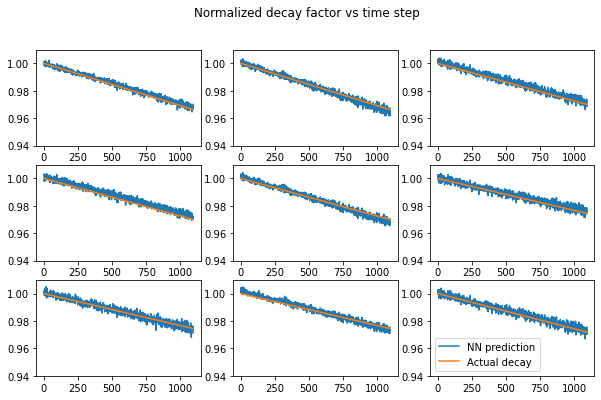

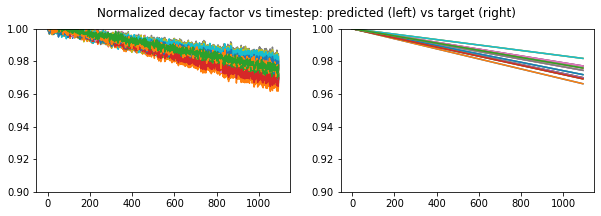

In [320]:
# II. Visualizing the predictions.
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.suptitle("Normalized decay factor vs time step")
for i in range(0, min(len(prediction), 9)):
    plt.subplot(3,3,i+1)
    plt.ylim(0.94,1.01)
    plt.plot([x for x in prediction[i]])
    plt.plot([x for x in Y_test[i]])
plt.legend(['NN prediction','Actual decay'])
plt.show()

plt.figure(figsize=(10,3))
plt.suptitle("Normalized decay factor vs timestep: predicted (left) vs target (right)")
plt.subplot(1,2,1)
plt.ylim(0.90,1)
for i in range(0,len(prediction)):
    plt.plot(prediction[i])
plt.subplot(1,2,2)
plt.ylim(0.90,1)
for i in range(0,len(Y_test)):
    plt.plot(Y_test[i])
plt.show()

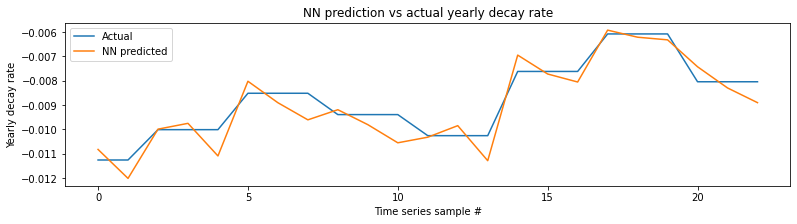

Model's degradation RMSE: 0.06013%/year
Model's R2: 0.84127


In [321]:
# IV. Computing the decay rates from the prediction and target, and
#      computing the RMSE between those.
model_pred = []
degradation_rates_test = []
for i in range(0,len(prediction)):
    model_pred.append(extract_yr_degrad(prediction[i]))
    degradation_rates_test.append(extract_yr_degrad(Y_test[i]))
    
plt.figure(figsize=(13,3))
plt.plot(degradation_rates_test[0:50])
plt.plot(model_pred[0:50])
plt.xlabel("Time series sample #")
plt.ylabel("Yearly decay rate")
plt.title("NN prediction vs actual yearly decay rate")
plt.legend(["Actual","NN predicted"])
plt.show()
    
mse = metrics.mean_squared_error(model_pred, degradation_rates_test)
print("Model's degradation RMSE: "+str(round(math.sqrt(mse)*100, 5))+"%/year")
print("Model's R2: "+str(round(sklearn.metrics.r2_score(degradation_rates_test, model_pred), 5)))

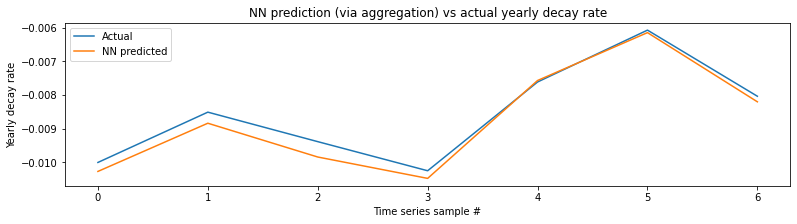

Model's degradation RMSE: 0.02607%/year
Model's R2: 0.96348


In [324]:
# V. For subsampling: aggregating predictions from the 3-year-long subsamples
#    coming from the same 5-year-long sample, and computing the RMSE.

model_pred_aggr = []
degrad_rate_aggr = []
for i in range(len(model_pred)%3,len(model_pred),3):
    degrad_rate_aggr.append(degradation_rates_test[i])
    model_pred_aggr.append(np.mean(model_pred[i:i+3]))
    
plt.figure(figsize=(13,3))
plt.plot(degrad_rate_aggr)
plt.plot(model_pred_aggr)
plt.xlabel("Time series sample #")
plt.ylabel("Yearly decay rate")
plt.title("NN prediction (via aggregation) vs actual yearly decay rate")
plt.legend(["Actual","NN predicted"])
plt.show()

mse = metrics.mean_squared_error(model_pred_aggr, degrad_rate_aggr)
print("Model's degradation RMSE: "+str(round(math.sqrt(mse)*100, 5))+"%/year")
print("Model's R2: "+str(round(sklearn.metrics.r2_score(degrad_rate_aggr, model_pred_aggr), 5)))

### Best models

This section is left empty for you to copy/paste models and preprocessing that work well. Too often did I want to try a modification and ended up editing and then forgetting about the edits of a promising model.